# Trial 3 - Dynamic structured Protein Trimming

Protein Trimming Based on Binding Hotspot Analysis with Secondary Structure Preservation

This notebook provides a workflow to trim a target protein based on binding hotspot analysis 
while preserving complete secondary structure elements (α-helices and β-sheets).

This is dynamic version of trial 2.

## 0. Dependencies & Environment

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Tuple, Set, Dict
import warnings

from Bio.PDB import (
    PDBParser,
    PDBIO,
    Select,
    NeighborSearch,
    is_aa,
    Superimposer,
    Structure,
    Model,
    Chain,
    DSSP
)
from Bio.PDB.Polypeptide import is_aa

warnings.filterwarnings("ignore")
plt.rcParams.update({"figure.dpi": 120, "figure.figsize": (10, 8)})

## 1. Configuration and Data Loading

In [13]:
HOTSPOT_PDB = Path("./receptor_hotspots.pdb")
ORIGINAL_RECEPTOR = Path("./data/original_receptor.pdb")
OUTPUT_DIR = Path("./dssp_trimmed_proteins")
OUTPUT_DIR.mkdir(exist_ok=True)

# Chain identifiers
RECEPTOR_CHAINS = {'A'}  # Update if your receptor has multiple chains

# Trimming parameters
HOTSPOT_THRESHOLD = 5      # Minimum number of designs that must target a residue
EXPANSION_RADIUS = 8.0     # Expand selected regions by this distance (Å)
MIN_FRAGMENT_SIZE = 15     # Minimum size for continuous fragments
GAP_BRIDGE_DISTANCE = 10   # Bridge gaps smaller than this (in sequence)

# Secondary structure parameters
MIN_HELIX_LENGTH = 4       # Minimum length for α-helix
MIN_STRAND_LENGTH = 3      # Minimum length for β-strand
PRESERVE_SS_CONTEXT = 2    # Residues to preserve around secondary structures

## 2. Secondary Structure Analysis

In [14]:
import mdtraj as md
import tempfile

def analyze_secondary_structure(structure, dssp_path=None):
    """
    Analyze secondary structure using MDTraj.
    Returns dict of {(chain_id, res_id): ss_type}
    """
    # Save structure to temporary PDB file for MDTraj
    with tempfile.NamedTemporaryFile(suffix='.pdb', delete=False) as tmp:
        io = PDBIO()
        io.set_structure(structure)
        io.save(tmp.name)
        tmp_path = tmp.name
    
    try:
        # Load structure with MDTraj
        traj = md.load(tmp_path)
        
        # Compute secondary structure using DSSP algorithm in MDTraj
        ss_assignment = md.compute_dssp(traj, simplified=False)
        
        # Create mapping dictionary
        ss_dict = {}
        
        # Get topology for residue information
        topology = traj.topology
        
        for i, residue in enumerate(topology.residues):
            chain_id = residue.chain.chain_id
            if chain_id == '':  # MDTraj sometimes returns empty string for chain A
                chain_id = 'A'
            res_id = residue.resSeq
            
            # Map MDTraj SS codes to DSSP codes
            # MDTraj returns: H (α-helix), E (β-sheet), C (coil/loop)
            # We want DSSP codes: H, E, L (and variants)
            mdtraj_ss = ss_assignment[0, i]  # First frame, i-th residue
            
            if mdtraj_ss == 'H':
                ss_dict[(chain_id, res_id)] = 'H'
            elif mdtraj_ss == 'E':
                ss_dict[(chain_id, res_id)] = 'E'
            elif mdtraj_ss == 'G':  # 3-10 helix
                ss_dict[(chain_id, res_id)] = 'G'
            elif mdtraj_ss == 'I':  # π-helix
                ss_dict[(chain_id, res_id)] = 'I'
            elif mdtraj_ss == 'B':  # β-bridge
                ss_dict[(chain_id, res_id)] = 'B'
            elif mdtraj_ss == 'T':  # Turn
                ss_dict[(chain_id, res_id)] = 'T'
            elif mdtraj_ss == 'S':  # Bend
                ss_dict[(chain_id, res_id)] = 'S'
            else:  # Coil or unassigned
                ss_dict[(chain_id, res_id)] = 'L'
        
        # Clean up temporary file
        os.unlink(tmp_path)
        
        return ss_dict
        
    except Exception as e:
        print(f"Warning: Could not run MDTraj DSSP ({e}). Using fallback method.")
        # Clean up temporary file if it exists
        if os.path.exists(tmp_path):
            os.unlink(tmp_path)
        return analyze_secondary_structure_fallback(structure)

def analyze_secondary_structure_fallback(structure):
    """
    Fallback method for secondary structure assignment based on phi/psi angles.
    """
    from Bio.PDB.Polypeptide import PPBuilder
    
    ppb = PPBuilder()
    ss_dict = {}
    
    for model in structure:
        for chain in model:
            if chain.id not in RECEPTOR_CHAINS:
                continue
                
            peptides = ppb.build_peptides(chain)
            for peptide in peptides:
                phi_psi = peptide.get_phi_psi_list()
                
                for i, residue in enumerate(peptide):
                    phi, psi = phi_psi[i]
                    chain_id = residue.get_parent().id
                    res_id = residue.id[1]
                    
                    # Simple classification based on Ramachandran regions
                    if phi and psi:
                        if -80 <= phi <= -40 and -60 <= psi <= -20:
                            ss_dict[(chain_id, res_id)] = 'H'  # Helix
                        elif -140 <= phi <= -90 and 90 <= psi <= 150:
                            ss_dict[(chain_id, res_id)] = 'E'  # Strand
                        else:
                            ss_dict[(chain_id, res_id)] = 'L'  # Loop
                    else:
                        ss_dict[(chain_id, res_id)] = 'L'
                        
    return ss_dict

def identify_ss_elements(ss_dict, chain_id):
    """
    Identify continuous secondary structure elements.
    Returns lists of helices and strands as residue ranges.
    """
    chain_residues = sorted([(res_id, ss_type) for (c_id, res_id), ss_type in ss_dict.items() 
                            if c_id == chain_id])
    
    helices = []
    strands = []
    current_helix = []
    current_strand = []
    
    for res_id, ss_type in chain_residues:
        # Process helices
        if ss_type in ['H', 'G', 'I']:  # Different helix types
            if not current_helix or (current_helix and res_id - current_helix[-1] == 1):
                current_helix.append(res_id)
            else:
                if len(current_helix) >= MIN_HELIX_LENGTH:
                    helices.append(current_helix)
                current_helix = [res_id]
        else:
            if len(current_helix) >= MIN_HELIX_LENGTH:
                helices.append(current_helix)
            current_helix = []
            
        # Process strands
        if ss_type in ['E', 'B']:  # Extended strand or isolated bridge
            if not current_strand or (current_strand and res_id - current_strand[-1] == 1):
                current_strand.append(res_id)
            else:
                if len(current_strand) >= MIN_STRAND_LENGTH:
                    strands.append(current_strand)
                current_strand = [res_id]
        else:
            if len(current_strand) >= MIN_STRAND_LENGTH:
                strands.append(current_strand)
            current_strand = []
    
    # Don't forget the last elements
    if len(current_helix) >= MIN_HELIX_LENGTH:
        helices.append(current_helix)
    if len(current_strand) >= MIN_STRAND_LENGTH:
        strands.append(current_strand)
        
    return helices, strands


## 3. Load Data and Analyze Structure

In [15]:
parser = PDBParser(QUIET=True)

def extract_hotspot_frequencies(pdb_path):
    """Extract B-factor values representing binding frequencies from hotspot PDB."""
    struct = parser.get_structure('hotspot', pdb_path)
    hotspot_data = {}

    for model in struct:
        for chain in model:
            if chain.id not in RECEPTOR_CHAINS:
                continue
            for residue in chain:
                if is_aa(residue, standard=True):
                    # Use average B-factor of all atoms in residue
                    avg_bfactor = np.mean([atom.bfactor for atom in residue])
                    hotspot_data[(chain.id, residue.id[1])] = avg_bfactor

    return hotspot_data

# Load structures and data
receptor_struct = parser.get_structure('receptor', ORIGINAL_RECEPTOR)
hotspot_freq = extract_hotspot_frequencies(HOTSPOT_PDB)
ss_dict = analyze_secondary_structure(receptor_struct)

print(f"Loaded {len(hotspot_freq)} residues with hotspot data")
print(f"Identified secondary structure for {len(ss_dict)} residues")

# Analyze secondary structure elements
all_helices = {}
all_strands = {}
for chain_id in RECEPTOR_CHAINS:
    helices, strands = identify_ss_elements(ss_dict, chain_id)
    all_helices[chain_id] = helices
    all_strands[chain_id] = strands
    
    print(f"\nChain {chain_id}:")
    print(f"  Found {len(helices)} α-helices")
    print(f"  Found {len(strands)} β-strands")

Loaded 475 residues with hotspot data
Identified secondary structure for 475 residues

Chain A:
  Found 17 α-helices
  Found 4 β-strands


## 4. Structure-Aware Trimming Strategy

In [16]:
def calculate_ss_element_score(element_residues, hotspot_freq, chain_id):
    """Calculate average hotspot score for a secondary structure element."""
    scores = [hotspot_freq.get((chain_id, res_id), 0) for res_id in element_residues]
    return np.mean(scores) if scores else 0

def select_ss_elements_to_keep(helices, strands, hotspot_freq, chain_id, threshold):
    """
    Select which complete secondary structure elements to keep based on hotspot scores.
    """
    kept_elements = set()
    
    # Evaluate each helix
    helix_scores = []
    for helix in helices:
        score = calculate_ss_element_score(helix, hotspot_freq, chain_id)
        helix_scores.append((helix, score, 'helix'))
        
        # Keep if any residue exceeds threshold or average is high
        if any(hotspot_freq.get((chain_id, res_id), 0) >= threshold for res_id in helix) or \
           score >= threshold * 0.5:
            for res_id in helix:
                kept_elements.add(res_id)
    
    # Evaluate each strand
    strand_scores = []
    for strand in strands:
        score = calculate_ss_element_score(strand, hotspot_freq, chain_id)
        strand_scores.append((strand, score, 'strand'))
        
        if any(hotspot_freq.get((chain_id, res_id), 0) >= threshold for res_id in strand) or \
           score >= threshold * 0.5:
            for res_id in strand:
                kept_elements.add(res_id)
    
    return kept_elements, helix_scores, strand_scores

def add_loop_residues(kept_ss_residues, hotspot_freq, ss_dict, chain_id, threshold):
    """
    Add loop residues that have high hotspot scores or connect kept SS elements.
    """
    all_residues = set(kept_ss_residues)
    
    # Add high-scoring loop residues
    for (c_id, res_id), freq in hotspot_freq.items():
        if c_id != chain_id:
            continue
            
        ss_type = ss_dict.get((c_id, res_id), 'L')
        if ss_type in ['L', 'T', 'S', '-'] and freq >= threshold:
            all_residues.add(res_id)
    
    # Add residues that bridge kept elements (if gap is small)
    sorted_residues = sorted(all_residues)
    bridged_residues = set(all_residues)
    
    for i in range(len(sorted_residues) - 1):
        gap = sorted_residues[i+1] - sorted_residues[i] - 1
        if 0 < gap <= GAP_BRIDGE_DISTANCE:
            # Check if bridging residues are loops
            bridge_is_loop = True
            for j in range(sorted_residues[i] + 1, sorted_residues[i+1]):
                if ss_dict.get((chain_id, j), 'L') not in ['L', 'T', 'S', '-']:
                    bridge_is_loop = False
                    break
            
            if bridge_is_loop:
                for j in range(sorted_residues[i] + 1, sorted_residues[i+1]):
                    bridged_residues.add(j)
    
    return bridged_residues

def expand_with_context(residues, ss_dict, chain_id, context_size=2):
    """
    Add context residues around secondary structures to preserve their stability.
    """
    expanded = set(residues)
    
    for res_id in list(residues):
        # Add N-terminal context
        for i in range(1, context_size + 1):
            context_id = res_id - i
            if ss_dict.get((chain_id, context_id), 'L') in ['L', 'T', 'S', '-']:
                expanded.add(context_id)
            else:
                break  # Stop if we hit another SS element
        
        # Add C-terminal context
        for i in range(1, context_size + 1):
            context_id = res_id + i
            if ss_dict.get((chain_id, context_id), 'L') in ['L', 'T', 'S', '-']:
                expanded.add(context_id)
            else:
                break
    
    return expanded

## 5. Apply Structure-Aware Trimming

In [17]:
# Calculate original residue count first
original_residue_count = sum(1 for model in receptor_struct for chain in model
                           for res in chain if is_aa(res, standard=True))
print(f"Original structure contains {original_residue_count} residues")

def perform_structure_aware_trimming(hotspot_threshold, ss_threshold_factor=0.5, 
                                    gap_bridge_distance=10, preserve_context=2):
    """
    Perform structure-aware trimming with given parameters.
    Returns final_residues set and detailed report.
    """
    final_residues = set()
    ss_element_report = {}
    
    for chain_id in RECEPTOR_CHAINS:
        # Step 1: Select complete SS elements to keep
        kept_ss, helix_scores, strand_scores = select_ss_elements_to_keep_with_factor(
            all_helices[chain_id], all_strands[chain_id], 
            hotspot_freq, chain_id, hotspot_threshold, ss_threshold_factor
        )
        
        # Step 2: Add important loop residues
        with_loops = add_loop_residues(kept_ss, hotspot_freq, ss_dict, chain_id, hotspot_threshold)
        
        # Step 3: Add context residues
        with_context = expand_with_context(with_loops, ss_dict, chain_id, preserve_context)
        
        # Step 4: Bridge gaps
        final_chain_residues = bridge_gaps_in_selection(with_context, chain_id, gap_bridge_distance)
        
        # Store results
        chain_residues = [(chain_id, res_id) for res_id in final_chain_residues]
        final_residues.update(chain_residues)
        
        ss_element_report[chain_id] = {
            'helix_scores': helix_scores,
            'strand_scores': strand_scores,
            'kept_residues': final_chain_residues
        }
    
    return final_residues, ss_element_report

def select_ss_elements_to_keep_with_factor(helices, strands, hotspot_freq, chain_id, 
                                          threshold, ss_threshold_factor):
    """
    Modified version that accepts a threshold factor for SS elements.
    """
    kept_elements = set()
    
    # Evaluate each helix
    helix_scores = []
    for helix in helices:
        score = calculate_ss_element_score(helix, hotspot_freq, chain_id)
        helix_scores.append((helix, score, 'helix'))
        
        # Keep if any residue exceeds threshold or average is high
        if any(hotspot_freq.get((chain_id, res_id), 0) >= threshold for res_id in helix) or \
           score >= threshold * ss_threshold_factor:
            for res_id in helix:
                kept_elements.add(res_id)
    
    # Evaluate each strand
    strand_scores = []
    for strand in strands:
        score = calculate_ss_element_score(strand, hotspot_freq, chain_id)
        strand_scores.append((strand, score, 'strand'))
        
        if any(hotspot_freq.get((chain_id, res_id), 0) >= threshold for res_id in strand) or \
           score >= threshold * ss_threshold_factor:
            for res_id in strand:
                kept_elements.add(res_id)
    
    return kept_elements, helix_scores, strand_scores

def bridge_gaps_in_selection(residues, chain_id, max_gap):
    """
    Bridge gaps in the selected residues.
    """
    sorted_residues = sorted(residues)
    if not sorted_residues:
        return residues
    
    bridged = set(residues)
    
    for i in range(len(sorted_residues) - 1):
        gap = sorted_residues[i+1] - sorted_residues[i] - 1
        if 0 < gap <= max_gap:
            # Check if bridging residues are loops
            bridge_is_loop = True
            for j in range(sorted_residues[i] + 1, sorted_residues[i+1]):
                if ss_dict.get((chain_id, j), 'L') not in ['L', 'T', 'S', '-']:
                    bridge_is_loop = False
                    break
            
            if bridge_is_loop:
                for j in range(sorted_residues[i] + 1, sorted_residues[i+1]):
                    bridged.add(j)
    
    return bridged

def find_optimal_parameters(target_retention, tolerance=0.05, max_iterations=20):
    """
    Find optimal parameters to achieve target retention rate.
    """
    # Initial parameter ranges
    param_ranges = {
        'hotspot_threshold': (0.0, 10.0),
        'ss_threshold_factor': (0.1, 0.8),
        'gap_bridge_distance': (5, 25),
        'preserve_context': (1, 4)
    }
    
    # Start with middle values
    current_params = {
        'hotspot_threshold': 5.0,
        'ss_threshold_factor': 0.5,
        'gap_bridge_distance': 10,
        'preserve_context': 2
    }
    
    best_params = None
    best_diff = float('inf')
    
    for iteration in range(max_iterations):
        # Run trimming with current parameters
        final_residues, ss_report = perform_structure_aware_trimming(**current_params)
        retention_rate = len(final_residues) / original_residue_count
        
        diff = abs(retention_rate - target_retention)
        
        # Update best if closer to target
        if diff < best_diff:
            best_diff = diff
            best_params = current_params.copy()
            best_residues = final_residues
            best_report = ss_report
        
        # Check if within tolerance
        if diff <= tolerance:
            print(f"  Iteration {iteration + 1}: Found parameters with retention {retention_rate:.3f}")
            return best_params, best_residues, best_report, retention_rate
        
        # Adjust parameters based on current retention
        if retention_rate < target_retention:  # Need to keep more
            # Decrease thresholds, increase bridging
            current_params['hotspot_threshold'] *= 0.85
            current_params['ss_threshold_factor'] *= 0.85
            current_params['gap_bridge_distance'] = min(
                current_params['gap_bridge_distance'] + 2,
                param_ranges['gap_bridge_distance'][1]
            )
        else:  # Need to keep less
            # Increase thresholds, decrease bridging
            current_params['hotspot_threshold'] *= 1.15
            current_params['ss_threshold_factor'] *= 1.15
            current_params['gap_bridge_distance'] = max(
                current_params['gap_bridge_distance'] - 2,
                param_ranges['gap_bridge_distance'][0]
            )
        
        # Ensure parameters stay within bounds
        for param, (min_val, max_val) in param_ranges.items():
            if param in current_params:
                current_params[param] = max(min_val, min(max_val, current_params[param]))
        
        # For integer parameters
        current_params['gap_bridge_distance'] = int(current_params['gap_bridge_distance'])
        current_params['preserve_context'] = int(current_params['preserve_context'])
    
    print(f"  Max iterations reached. Best retention: {retention_rate:.3f}")
    return best_params, best_residues, best_report, retention_rate

# Generate three candidate structures with different retention rates
print("\n" + "="*60)
print("GENERATING CANDIDATE STRUCTURES")
print("="*60)

# Define target retention rates
target_retentions = [0.75, 0.8, 0.95]
candidate_names = ['aggressive', 'moderate', 'conservative']

all_candidates = {}

for target, name in zip(target_retentions, candidate_names):
    print(f"\n{name.upper()} candidate (target: {target*100:.0f}% retention):")
    
    # Find optimal parameters
    params, residues, report, actual_retention = find_optimal_parameters(
        target, tolerance=0.05, max_iterations=15
    )
    
    print(f"  Actual retention: {actual_retention*100:.1f}%")
    print(f"  Parameters:")
    print(f"    - Hotspot threshold: {params['hotspot_threshold']:.2f}")
    print(f"    - SS threshold factor: {params['ss_threshold_factor']:.2f}")
    print(f"    - Gap bridge distance: {params['gap_bridge_distance']}")
    print(f"    - Context preservation: {params['preserve_context']}")
    
    # Count preserved structures
    total_helices = 0
    kept_helices = 0
    total_strands = 0
    kept_strands = 0
    
    for chain_id in RECEPTOR_CHAINS:
        helix_scores = report[chain_id]['helix_scores']
        strand_scores = report[chain_id]['strand_scores']
        kept_residues = report[chain_id]['kept_residues']
        
        total_helices += len(helix_scores)
        kept_helices += len([h for h, _, _ in helix_scores if any(r in kept_residues for r in h)])
        total_strands += len(strand_scores)
        kept_strands += len([s for s, _, _ in strand_scores if any(r in kept_residues for r in s)])
    
    print(f"  Secondary structures: {kept_helices}/{total_helices} helices, {kept_strands}/{total_strands} strands")
    
    # Store candidate information
    all_candidates[name] = {
        'parameters': params,
        'residues': residues,
        'report': report,
        'retention': actual_retention,
        'residue_count': len(residues)
    }
    
    # Save structure
    io = PDBIO()
    io.set_structure(receptor_struct)
    select = TrimmedProteinSelect(residues)
    output_path = OUTPUT_DIR / f'trimmed_receptor_{name}.pdb'
    io.save(str(output_path), select)
    print(f"  Saved: trimmed_receptor_{name}.pdb")

# Update global variables with moderate candidate for downstream analysis
final_residues = all_candidates['moderate']['residues']
ss_element_report = all_candidates['moderate']['report']
print(f"\n{'='*60}")
print(f"Using MODERATE candidate for detailed analysis and visualization")
print(f"Total residues in moderate structure: {len(final_residues)}")
reduction_percent = (1 - len(final_residues) / original_residue_count) * 100
print(f"Size reduction: {reduction_percent:.1f}%")


Original structure contains 475 residues

GENERATING CANDIDATE STRUCTURES

AGGRESSIVE candidate (target: 75% retention):
  Max iterations reached. Best retention: 0.398
  Actual retention: 39.8%
  Parameters:
    - Hotspot threshold: 0.98
    - SS threshold factor: 0.10
    - Gap bridge distance: 25
    - Context preservation: 2
  Secondary structures: 8/17 helices, 1/4 strands
  Saved: trimmed_receptor_aggressive.pdb

MODERATE candidate (target: 80% retention):
  Max iterations reached. Best retention: 0.398
  Actual retention: 39.8%
  Parameters:
    - Hotspot threshold: 0.98
    - SS threshold factor: 0.10
    - Gap bridge distance: 25
    - Context preservation: 2
  Secondary structures: 8/17 helices, 1/4 strands
  Saved: trimmed_receptor_moderate.pdb

CONSERVATIVE candidate (target: 95% retention):
  Max iterations reached. Best retention: 0.398
  Actual retention: 39.8%
  Parameters:
    - Hotspot threshold: 0.98
    - SS threshold factor: 0.10
    - Gap bridge distance: 25
    -

## 6. Visualize Structure-Aware Trimming

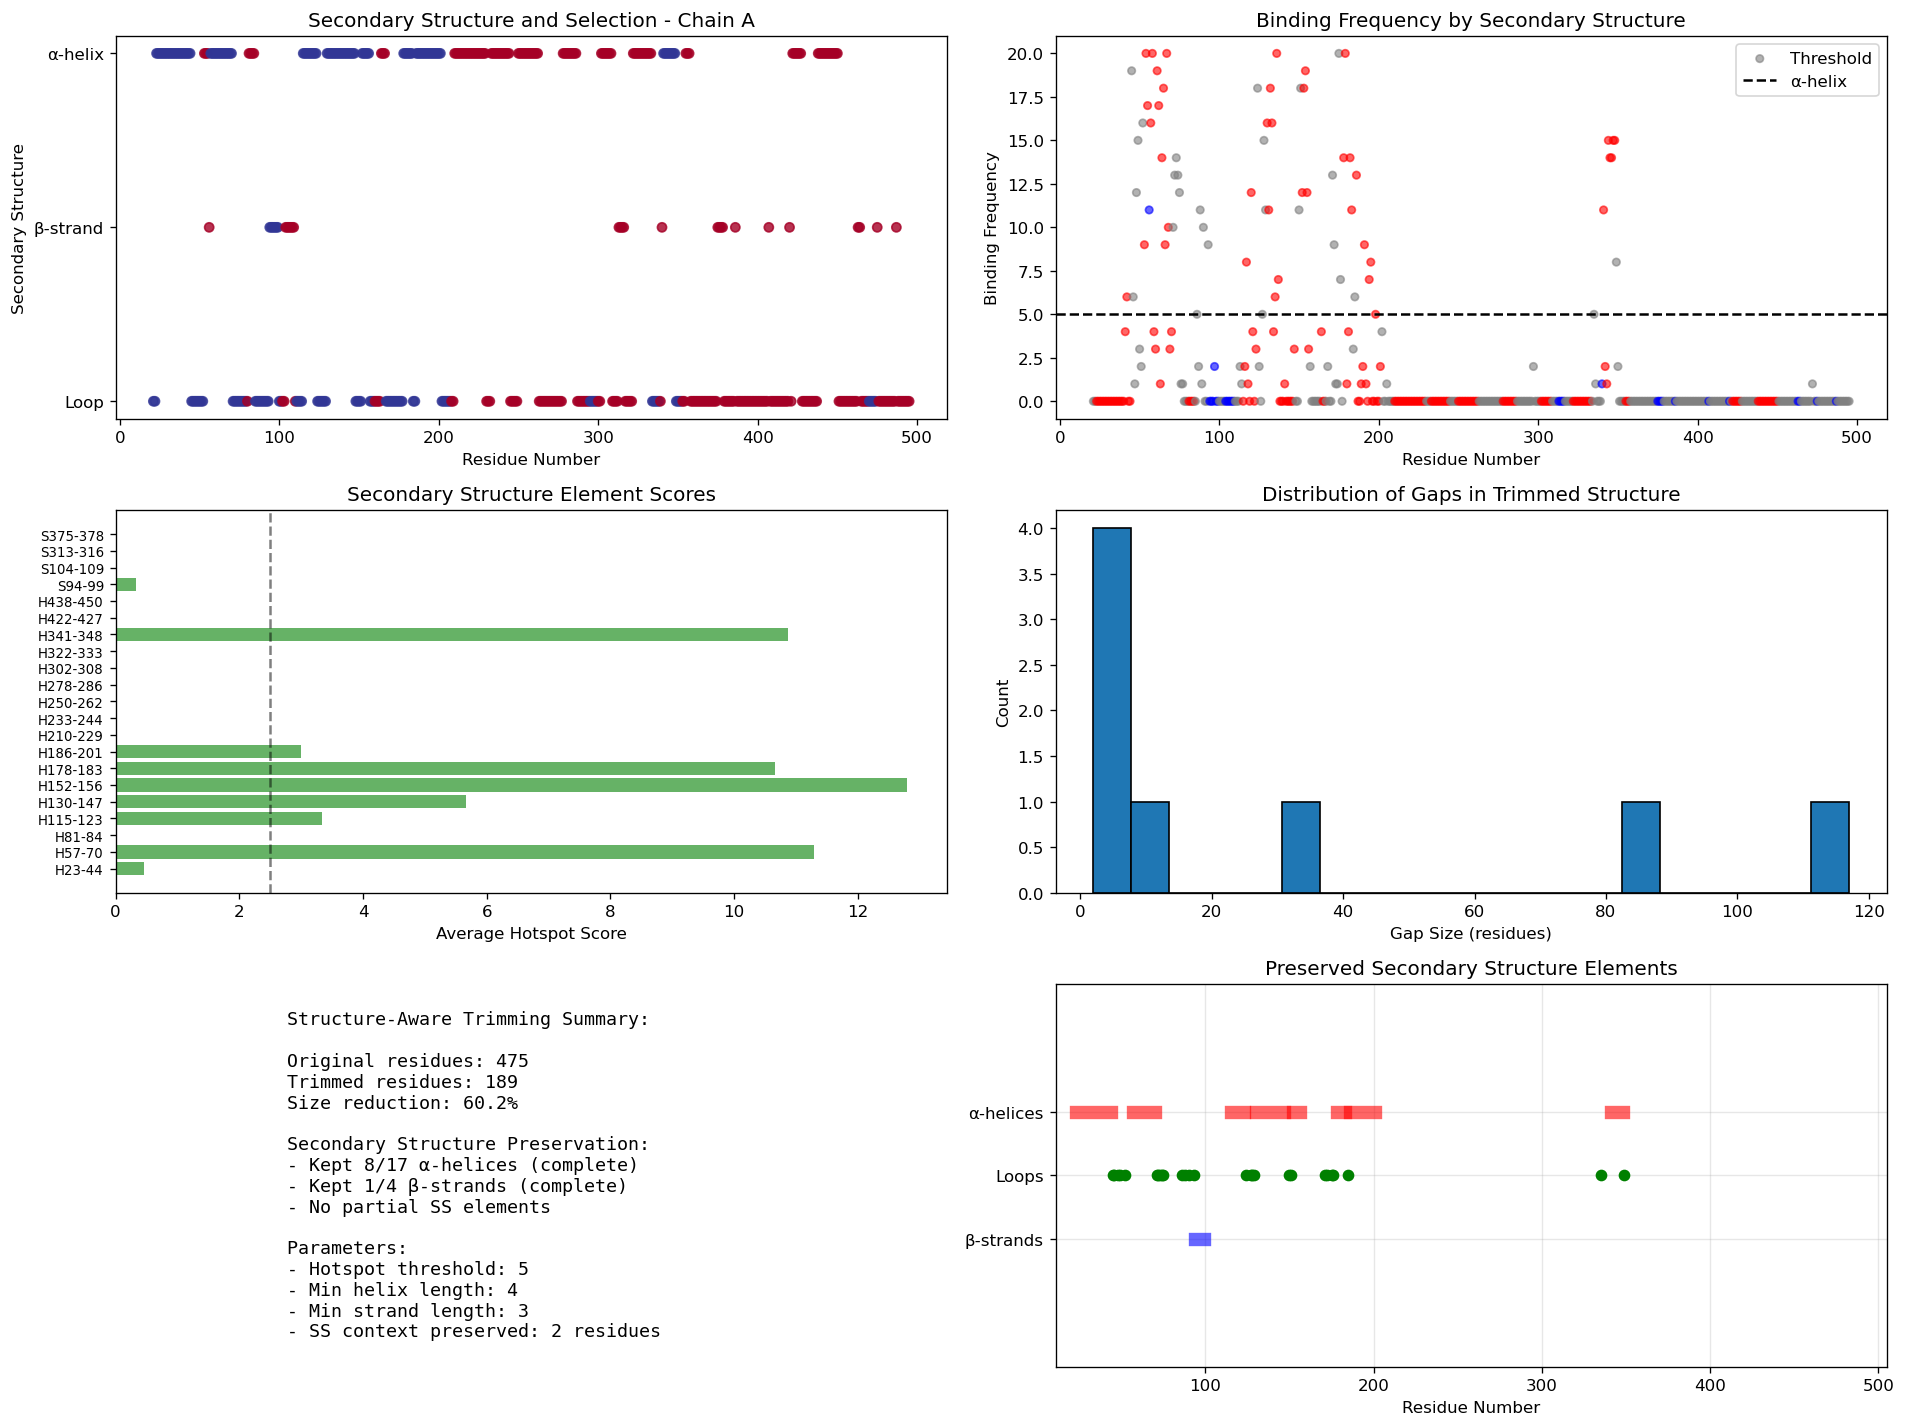

In [18]:
def create_ss_trimming_report(struct, selected_residues, hotspot_freq, ss_dict, ss_report):
    """Create visualization of structure-aware trimming results."""
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    
    for chain_id in RECEPTOR_CHAINS:
        # 1. Secondary structure map with selection
        ax = axes[0, 0]
        chain_res = []
        ss_types = []
        selected = []
        
        for model in struct:
            if chain_id in model:
                chain = model[chain_id]
                for res in chain:
                    if is_aa(res, standard=True):
                        res_id = res.id[1]
                        chain_res.append(res_id)
                        ss_type = ss_dict.get((chain_id, res_id), 'L')
                        
                        # Convert to numeric for coloring
                        if ss_type in ['H', 'G', 'I']:
                            ss_types.append(2)  # Helix
                        elif ss_type in ['E', 'B']:
                            ss_types.append(1)  # Strand
                        else:
                            ss_types.append(0)  # Loop
                            
                        selected.append(1 if (chain_id, res_id) in selected_residues else 0.3)
        
        scatter = ax.scatter(chain_res, ss_types, c=selected, s=30, cmap='RdYlBu', alpha=0.8)
        ax.set_xlabel('Residue Number')
        ax.set_ylabel('Secondary Structure')
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(['Loop', 'β-strand', 'α-helix'])
        ax.set_title(f'Secondary Structure and Selection - Chain {chain_id}')
        
        # 2. Hotspot scores with SS overlay
        ax = axes[0, 1]
        frequencies = [hotspot_freq.get((chain_id, r), 0) for r in chain_res]
        colors = ['red' if s == 2 else 'blue' if s == 1 else 'gray' for s in ss_types]
        
        ax.scatter(chain_res, frequencies, c=colors, s=20, alpha=0.6)
        ax.axhline(y=HOTSPOT_THRESHOLD, color='black', linestyle='--', label=f'Threshold={HOTSPOT_THRESHOLD}')
        ax.set_xlabel('Residue Number')
        ax.set_ylabel('Binding Frequency')
        ax.set_title('Binding Frequency by Secondary Structure')
        ax.legend(['Threshold', 'α-helix', 'β-strand', 'Loop'])
        
        # 3. SS element scores
        ax = axes[1, 0]
        helix_scores = ss_report[chain_id]['helix_scores']
        strand_scores = ss_report[chain_id]['strand_scores']
        
        if helix_scores or strand_scores:
            elements = []
            scores = []
            types = []
            kept = []
            
            for helix, score, _ in helix_scores:
                elements.append(f"H{helix[0]}-{helix[-1]}")
                scores.append(score)
                types.append('Helix')
                kept.append(any(r in ss_report[chain_id]['kept_residues'] for r in helix))
            
            for strand, score, _ in strand_scores:
                elements.append(f"S{strand[0]}-{strand[-1]}")
                scores.append(score)
                types.append('Strand')
                kept.append(any(r in ss_report[chain_id]['kept_residues'] for r in strand))
            
            colors = ['green' if k else 'red' for k in kept]
            y_pos = np.arange(len(elements))
            
            ax.barh(y_pos, scores, color=colors, alpha=0.6)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(elements, fontsize=8)
            ax.set_xlabel('Average Hotspot Score')
            ax.set_title('Secondary Structure Element Scores')
            ax.axvline(x=HOTSPOT_THRESHOLD * 0.5, color='black', linestyle='--', alpha=0.5)
        
        # 4. Fragment continuity
        ax = axes[1, 1]
        sorted_kept = sorted(ss_report[chain_id]['kept_residues'])
        if sorted_kept:
            gaps = []
            for i in range(1, len(sorted_kept)):
                gap = sorted_kept[i] - sorted_kept[i-1] - 1
                if gap > 0:
                    gaps.append(gap)
            
            if gaps:
                ax.hist(gaps, bins=20, edgecolor='black')
                ax.set_xlabel('Gap Size (residues)')
                ax.set_ylabel('Count')
                ax.set_title('Distribution of Gaps in Trimmed Structure')
            else:
                ax.text(0.5, 0.5, 'No gaps - continuous structure', 
                       ha='center', va='center', transform=ax.transAxes)
        
        # 5. Summary statistics
        ax = axes[2, 0]
        ax.axis('off')
        
        kept_helices = len([h for h, s, _ in helix_scores if any(r in ss_report[chain_id]['kept_residues'] for r in h)])
        kept_strands = len([s for s, sc, _ in strand_scores if any(r in ss_report[chain_id]['kept_residues'] for r in s)])
        
        summary_text = f"""
        Structure-Aware Trimming Summary:
        
        Original residues: {original_residue_count}
        Trimmed residues: {len(selected_residues)}
        Size reduction: {reduction_percent:.1f}%
        
        Secondary Structure Preservation:
        - Kept {kept_helices}/{len(helix_scores)} α-helices (complete)
        - Kept {kept_strands}/{len(strand_scores)} β-strands (complete)
        - No partial SS elements
        
        Parameters:
        - Hotspot threshold: {HOTSPOT_THRESHOLD}
        - Min helix length: {MIN_HELIX_LENGTH}
        - Min strand length: {MIN_STRAND_LENGTH}
        - SS context preserved: {PRESERVE_SS_CONTEXT} residues
        """
        ax.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center', 
                fontfamily='monospace')
        
        # 6. Visual representation of kept elements
        ax = axes[2, 1]
        ax.set_xlim(min(chain_res) - 10, max(chain_res) + 10)
        ax.set_ylim(-0.5, 2.5)
        
        # Draw secondary structures
        for helix, score, _ in helix_scores:
            if any(r in ss_report[chain_id]['kept_residues'] for r in helix):
                ax.plot([helix[0], helix[-1]], [1.5, 1.5], 'r-', linewidth=8, alpha=0.6)
                
        for strand, score, _ in strand_scores:
            if any(r in ss_report[chain_id]['kept_residues'] for r in strand):
                ax.plot([strand[0], strand[-1]], [0.5, 0.5], 'b-', linewidth=8, alpha=0.6)
        
        # Mark high-scoring loops
        for res_id in sorted_kept:
            if ss_dict.get((chain_id, res_id), 'L') in ['L', 'T', 'S', '-']:
                if hotspot_freq.get((chain_id, res_id), 0) >= HOTSPOT_THRESHOLD:
                    ax.plot(res_id, 1, 'go', markersize=6)
        
        ax.set_xlabel('Residue Number')
        ax.set_yticks([0.5, 1, 1.5])
        ax.set_yticklabels(['β-strands', 'Loops', 'α-helices'])
        ax.set_title('Preserved Secondary Structure Elements')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Create report
report_fig = create_ss_trimming_report(receptor_struct, final_residues, hotspot_freq, ss_dict, ss_element_report)
plt.savefig(OUTPUT_DIR / 'ss_aware_trimming_report.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Export Structure-Aware Trimmed Structure

In [19]:
class TrimmedProteinSelect(Select):
    """Selection class for creating trimmed protein."""
    def __init__(self, selected_residues):
        self.selected_residues = selected_residues

    def accept_residue(self, residue):
        chain_id = residue.get_parent().id
        res_id = residue.id[1]
        return (chain_id, res_id) in self.selected_residues

# Save all candidate structures with different visualizations
print("\n" + "="*60)
print("SAVING ALL CANDIDATE STRUCTURES")
print("="*60)

for name, candidate in all_candidates.items():
    residues = candidate['residues']
    
    # Save with hotspot scores in B-factor
    trimmed_struct = parser.get_structure('trimmed', OUTPUT_DIR / f'trimmed_receptor_{name}.pdb')
    for model in trimmed_struct:
        for chain in model:
            for residue in chain:
                freq = hotspot_freq.get((chain.id, residue.id[1]), 0)
                for atom in residue:
                    atom.bfactor = freq
    
    io = PDBIO()
    io.set_structure(trimmed_struct)
    io.save(str(OUTPUT_DIR / f'trimmed_receptor_{name}_with_scores.pdb'))
    print(f"Saved: trimmed_receptor_{name}_with_scores.pdb")
    
    # Save with secondary structure in B-factor
    for model in trimmed_struct:
        for chain in model:
            for residue in chain:
                ss_type = ss_dict.get((chain.id, residue.id[1]), 'L')
                # Encode SS type as B-factor
                if ss_type in ['H', 'G', 'I']:
                    bfactor = 100.0  # Helix
                elif ss_type in ['E', 'B']:
                    bfactor = 50.0   # Strand
                else:
                    bfactor = 0.0    # Loop
                    
                for atom in residue:
                    atom.bfactor = bfactor
    
    io.set_structure(trimmed_struct)
    io.save(str(OUTPUT_DIR / f'trimmed_receptor_{name}_ss_colored.pdb'))
    print(f"Saved: trimmed_receptor_{name}_ss_colored.pdb")



SAVING ALL CANDIDATE STRUCTURES
Saved: trimmed_receptor_aggressive_with_scores.pdb
Saved: trimmed_receptor_aggressive_ss_colored.pdb
Saved: trimmed_receptor_moderate_with_scores.pdb
Saved: trimmed_receptor_moderate_ss_colored.pdb
Saved: trimmed_receptor_conservative_with_scores.pdb
Saved: trimmed_receptor_conservative_ss_colored.pdb


## 8. Export Detailed Metadata

In [20]:

# Create comprehensive metadata for all candidates
all_metadata = {
    'original_receptor': str(ORIGINAL_RECEPTOR),
    'original_residue_count': original_residue_count,
    'candidates': {}
}

for name, candidate in all_candidates.items():
    params = candidate['parameters']
    residues = candidate['residues']
    report = candidate['report']
    retention = candidate['retention']
    
    candidate_metadata = {
        'trimming_parameters': params,
        'statistics': {
            'trimmed_residue_count': len(residues),
            'retention_rate': retention,
            'size_reduction_percent': (1 - retention) * 100
        },
        'secondary_structure_preservation': {}
    }
    
    # Add detailed SS preservation info for each chain
    for chain_id in RECEPTOR_CHAINS:
        helix_scores = report[chain_id]['helix_scores']
        strand_scores = report[chain_id]['strand_scores']
        kept_residues = report[chain_id]['kept_residues']
        
        kept_helices = []
        removed_helices = []
        for helix, score, _ in helix_scores:
            helix_info = {
                'start': helix[0],
                'end': helix[-1],
                'length': len(helix),
                'avg_hotspot_score': float(score),
                'max_hotspot_score': float(max(hotspot_freq.get((chain_id, r), 0) for r in helix))
            }
            if any(r in kept_residues for r in helix):
                kept_helices.append(helix_info)
            else:
                removed_helices.append(helix_info)
        
        kept_strands = []
        removed_strands = []
        for strand, score, _ in strand_scores:
            strand_info = {
                'start': strand[0],
                'end': strand[-1],
                'length': len(strand),
                'avg_hotspot_score': float(score),
                'max_hotspot_score': float(max(hotspot_freq.get((chain_id, r), 0) for r in strand))
            }
            if any(r in kept_residues for r in strand):
                kept_strands.append(strand_info)
            else:
                removed_strands.append(strand_info)
        
        candidate_metadata['secondary_structure_preservation'][chain_id] = {
            'helices': {
                'total': len(helix_scores),
                'kept': len(kept_helices),
                'kept_details': kept_helices,
                'removed_details': removed_helices
            },
            'strands': {
                'total': len(strand_scores),
                'kept': len(kept_strands),
                'kept_details': kept_strands,
                'removed_details': removed_strands
            },
            'high_scoring_loops': [
                {
                    'residue': int(res_id),
                    'hotspot_score': float(hotspot_freq.get((chain_id, res_id), 0))
                }
                for res_id in kept_residues
                if ss_dict.get((chain_id, res_id), 'L') in ['L', 'T', 'S', '-'] and
                hotspot_freq.get((chain_id, res_id), 0) >= params['hotspot_threshold']
            ]
        }
    
    all_metadata['candidates'][name] = candidate_metadata

import json
with open(OUTPUT_DIR / 'adaptive_trimming_metadata.json', 'w') as f:
    json.dump(all_metadata, f, indent=2)
print("\nSaved: adaptive_trimming_metadata.json")



Saved: adaptive_trimming_metadata.json


## 9. Validation and Final Recommendations

In [21]:

print("\n" + "="*70)
print("ADAPTIVE STRUCTURE-AWARE TRIMMING COMPLETE - SUMMARY:")
print("="*70)

print("\n1. THREE CANDIDATE STRUCTURES GENERATED:")
print("   " + "-"*50)
for name in ['aggressive', 'moderate', 'conservative']:
    candidate = all_candidates[name]
    retention = candidate['retention']
    residue_count = candidate['residue_count']
    params = candidate['parameters']
    
    print(f"\n   {name.upper()} ({retention*100:.1f}% retention, {residue_count} residues):")
    print(f"   - Hotspot threshold: {params['hotspot_threshold']:.2f}")
    print(f"   - SS threshold factor: {params['ss_threshold_factor']:.2f}")
    print(f"   - Gap bridge distance: {params['gap_bridge_distance']}")
    
    # Count SS elements
    total_h = sum(len(candidate['report'][c]['helix_scores']) for c in RECEPTOR_CHAINS)
    kept_h = sum(len([h for h, _, _ in candidate['report'][c]['helix_scores'] 
                     if any(r in candidate['report'][c]['kept_residues'] for r in h)])
                 for c in RECEPTOR_CHAINS)
    total_s = sum(len(candidate['report'][c]['strand_scores']) for c in RECEPTOR_CHAINS)
    kept_s = sum(len([s for s, _, _ in candidate['report'][c]['strand_scores'] 
                     if any(r in candidate['report'][c]['kept_residues'] for r in s)])
                 for c in RECEPTOR_CHAINS)
    
    print(f"   - Secondary structures: {kept_h}/{total_h} helices, {kept_s}/{total_s} strands")

print(f"\n2. TOP BINDING SITES (across all candidates):")
# Find consistently preserved hotspots
consensus_hotspots = []
for (chain_id, res_id), freq in hotspot_freq.items():
    if freq >= HOTSPOT_THRESHOLD:
        in_candidates = sum(1 for c in all_candidates.values() 
                          if (chain_id, res_id) in c['residues'])
        if in_candidates == 3:  # Present in all candidates
            consensus_hotspots.append((chain_id, res_id, freq))

consensus_hotspots.sort(key=lambda x: x[2], reverse=True)
print(f"   Residues preserved in ALL candidates (consensus binding sites):")
for i, (chain_id, res_id, freq) in enumerate(consensus_hotspots[:10], 1):
    ss_type = ss_dict.get((chain_id, res_id), 'L')
    ss_name = 'helix' if ss_type in ['H', 'G', 'I'] else 'strand' if ss_type in ['E', 'B'] else 'loop'
    print(f"   {i}. Chain {chain_id} Res {res_id} ({ss_name}): {freq:.0f} designs")

print(f"\n3. STRUCTURAL INTEGRITY COMPARISON:")
for name in ['aggressive', 'moderate', 'conservative']:
    candidate = all_candidates[name]
    residues = candidate['residues']
    
    # Calculate fragment statistics
    fragment_sizes = []
    for chain_id in RECEPTOR_CHAINS:
        chain_kept = sorted([r for (c, r) in residues if c == chain_id])
        if chain_kept:
            fragments = []
            current = [chain_kept[0]]
            for i in range(1, len(chain_kept)):
                if chain_kept[i] - chain_kept[i-1] == 1:
                    current.append(chain_kept[i])
                else:
                    fragments.append(current)
                    current = [chain_kept[i]]
            fragments.append(current)
            fragment_sizes.extend([len(f) for f in fragments])
    
    if fragment_sizes:
        print(f"\n   {name.upper()}:")
        print(f"   - Fragments: {len(fragment_sizes)}")
        print(f"   - Avg size: {np.mean(fragment_sizes):.1f} residues")
        print(f"   - Range: {min(fragment_sizes)}-{max(fragment_sizes)} residues")

print(f"\n4. RECOMMENDATIONS FOR BINDCRAFT:")
print("   " + "-"*50)
print("   a) START WITH MODERATE (65% retention):")
print("      - Balanced between size reduction and structure preservation")
print("      - Use: trimmed_receptor_moderate.pdb")
print("")
print("   b) IF BINDCRAFT FAILS with moderate:")
print("      - Too few hits → try CONSERVATIVE (80% retention)")
print("      - Still computationally expensive → try AGGRESSIVE (50% retention)")
print("")
print("   c) ALL candidates preserve:")
print("      - Complete secondary structure elements (no partial cuts)")
print("      - High-confidence binding sites")
print("      - Structural context around SS elements")

print(f"\n5. VISUALIZATION GUIDE:")
print("   Load 'visualize_candidates.pml' in PyMOL to compare all three candidates")
print("   - Cyan: Aggressive trimming")
print("   - Green: Moderate trimming")
print("   - Orange: Conservative trimming")
print("   - Use scenes to switch between structure/hotspot/SS views")

print(f"\n6. ADVANCED USAGE:")
print("   To generate custom retention rates, modify the target_retentions list:")
print("   ```python")
print("   target_retentions = [0.4, 0.6, 0.7, 0.9]  # 40%, 60%, 70%, 90%")
print("   ```")
print("   The adaptive algorithm will find optimal parameters for each target.")

print("\n" + "="*70)
print("Adaptive structure-aware trimming completed successfully!")
print("All candidate structures saved to:", OUTPUT_DIR)
print("="*70)


ADAPTIVE STRUCTURE-AWARE TRIMMING COMPLETE - SUMMARY:

1. THREE CANDIDATE STRUCTURES GENERATED:
   --------------------------------------------------

   AGGRESSIVE (39.8% retention, 189 residues):
   - Hotspot threshold: 0.98
   - SS threshold factor: 0.10
   - Gap bridge distance: 25
   - Secondary structures: 8/17 helices, 1/4 strands

   MODERATE (39.8% retention, 189 residues):
   - Hotspot threshold: 0.98
   - SS threshold factor: 0.10
   - Gap bridge distance: 25
   - Secondary structures: 8/17 helices, 1/4 strands

   CONSERVATIVE (39.8% retention, 189 residues):
   - Hotspot threshold: 0.98
   - SS threshold factor: 0.10
   - Gap bridge distance: 25
   - Secondary structures: 8/17 helices, 1/4 strands

2. TOP BINDING SITES (across all candidates):
   Residues preserved in ALL candidates (consensus binding sites):
   1. Chain A Res 58 (helix): 20 designs
   2. Chain A Res 67 (helix): 20 designs
   3. Chain A Res 136 (helix): 20 designs
   4. Chain A Res 175 (loop): 20 designs
